In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2

# Tamaño nuevo para las imágenes
IMAGE_SIZE = (128, 128)

# Cargar anotaciones
train_df = pd.read_csv('Dataset-SupermarketImages/annotations.csv')
val_df = pd.read_csv('Dataset-SupermarketImages/annotations_val.csv')

# Función para cargar imágenes
def load_images_and_labels(df, base_path='Dataset-SupermarketImages', image_size=IMAGE_SIZE):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(base_path, row['image'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img / 255.0)
        labels.append(row[1:].values.astype(int))
    return np.array(images), np.array(labels)

# Cargar datasets
x_train, y_train = load_images_and_labels(train_df)
x_val, y_val = load_images_and_labels(val_df)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),

    Dense(10, activation='softmax')  # Cambia a sigmoid si estás manejando multilabel, pero tú usas multiclass por ahora
])


In [31]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',      # Puedes usar también 'val_accuracy'
    patience=3,              # Cuántas épocas sin mejora esperar
    restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=15,
    callbacks=[early_stop]
)




Epoch 1/15
29/29 [==============================] - 1s 25ms/step - loss: 2.6768 - accuracy: 0.1733 - val_loss: 1.9962 - val_accuracy: 0.2800
Epoch 2/15
29/29 [==============================] - 1s 19ms/step - loss: 1.8481 - accuracy: 0.4011 - val_loss: 1.2471 - val_accuracy: 0.6800
Epoch 3/15
29/29 [==============================] - 1s 19ms/step - loss: 1.3793 - accuracy: 0.5667 - val_loss: 0.9530 - val_accuracy: 0.7800
Epoch 4/15
29/29 [==============================] - 1s 19ms/step - loss: 1.0189 - accuracy: 0.7078 - val_loss: 0.6520 - val_accuracy: 0.8600
Epoch 5/15
29/29 [==============================] - 1s 19ms/step - loss: 0.7468 - accuracy: 0.7989 - val_loss: 0.5629 - val_accuracy: 0.9200
Epoch 6/15
29/29 [==============================] - 1s 19ms/step - loss: 0.5347 - accuracy: 0.8789 - val_loss: 0.5139 - val_accuracy: 0.9000
Epoch 7/15
29/29 [==============================] - 1s 19ms/step - loss: 0.5115 - accuracy: 0.8867 - val_loss: 0.5175 - val_accuracy: 0.9200
Epoch 8/15
29

2/2 [==============================] - 0s 71ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.75      0.86         4
           6       0.83      1.00      0.91         5
           7       1.00      0.60      0.75         5
           8       1.00      1.00      1.00         5
           9       0.83      1.00      0.91         5

   micro avg       0.94      0.94      0.94        50
   macro avg       0.95      0.93      0.93        50
weighted avg       0.95      0.94      0.94        50
 samples avg       0.94      0.94      0.94        50



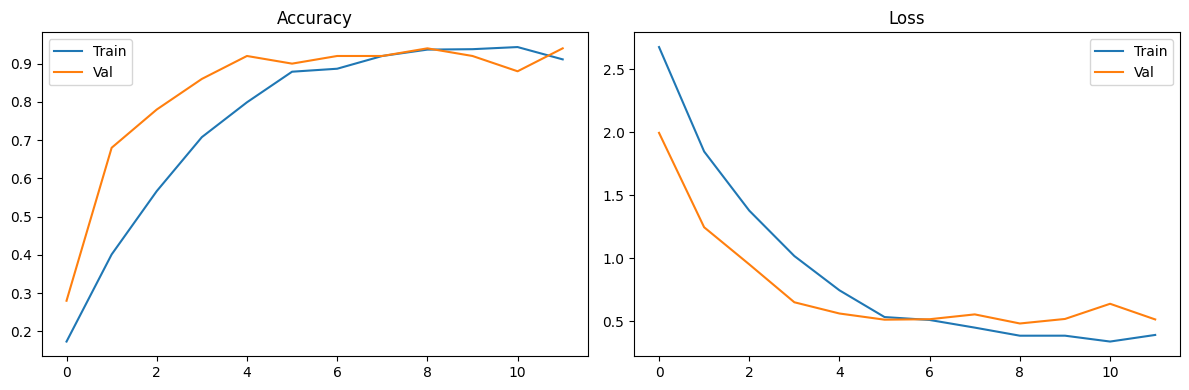

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Predicciones
y_pred = model.predict(x_val)
y_pred_bin = (y_pred > 0.5).astype(int)

# Reporte
print(classification_report(y_val, y_pred_bin, zero_division=0))

# Graficar entrenamiento
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()


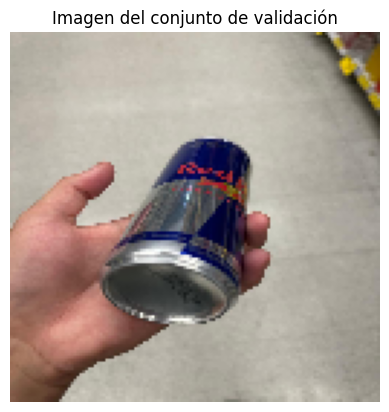

1/1 [==============================] - 0s 21ms/step
Etiquetas verdaderas:
['red_bull']

Etiquetas predichas:
['red_bull']


In [33]:
import random

idx = random.randint(0, len(x_val)-1)
img = x_val[idx]
true_labels = y_val[idx]

# Mostrar imagen
plt.imshow(img)
plt.axis('off')
plt.title("Imagen del conjunto de validación")
plt.show()

# Predicción
pred = model.predict(np.expand_dims(img, axis=0))[0]
pred_bin = (pred > 0.5).astype(int)

# Decodificar etiquetas
etiquetas = train_df.columns[1:]  # saltamos la columna 'image'
print("Etiquetas verdaderas:")
print([etiquetas[i] for i, v in enumerate(true_labels) if v == 1])

print("\nEtiquetas predichas:")
print([etiquetas[i] for i, v in enumerate(pred_bin) if v == 1])


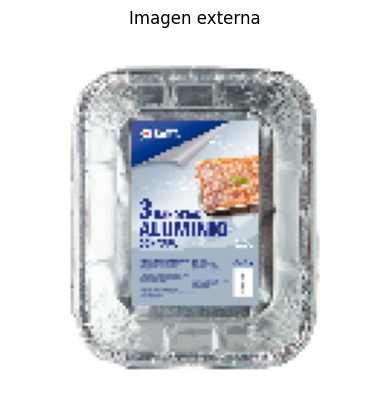

1/1 [==============================] - 0s 20ms/step
Etiquetas predichas para imagen externa:
[]


In [39]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ruta a la imagen externa (cámbiala tú si es otra)
ruta_img = 'ImagenesPrueba/prueba2.jpg'

# Preprocesamiento igual al entrenamiento
img_ext = load_img(ruta_img, target_size=IMAGE_SIZE)
img_array = img_to_array(img_ext) / 255.0

plt.imshow(img_array)
plt.axis('off')
plt.title("Imagen externa")
plt.show()

# Predicción
pred = model.predict(np.expand_dims(img_array, axis=0))[0]
pred_bin = (pred > 0.5).astype(int)

# Decodificar etiquetas
print("Etiquetas predichas para imagen externa:")
print([etiquetas[i] for i, v in enumerate(pred_bin) if v == 1])


In [40]:
model.save('modelo_cnn_multietiqueta.h5')